# [텀프로젝트: 제출일 2022년 11월 2-6일까지]
  AI Hub 사이트의 농축수산 분야 데이터를 사용하여 머신러닝 알고리즘(회귀, 분류, 군집) 3가지를 모두 적용하고 그 결과를 설명하시오. (단, 3가지 알고리즘별로 데이터를 다르게 적용하여도 됨) (100)
  아래 사이트로 접속하여도 됨
https://www.aihub.or.kr/aihubdata/data/list.do?currMenu=115&topMenu=100&srchDataRealmCode=REALM004 

# 감귤 궤양병 구분
* 제주도의 감귤 농장에서 궤양병에 걸린 감귤과 정상 감귤을 데이터화 하였고
* 궤양병이 있는 감귤과 정상 감귤을 인공지능으로 구분할 수 있다면 판매를 할때 실수로 궤양병이 있는 감귤을 팔 확률을 낮출수 있다고 생각하여 
* 궤양병이 있는 감귤과 정상 감귤을 머신러닝 알고리즘의 회귀, 분류, 군집화를 통해 구분해봤습니다.
* 데이터 설명
    * Training
        * 궤양병_감귤
        * 정상_감귤
    * Validation
        * 궤양병_감귤
        * 정상_감귤
* 궤양병_감귤의 데이터와 정상_감귤 데이터를 합쳐 Training Data로 만들고 나중에 train data와 test data로 나누어주었습니다.

# GPU

In [99]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2022-11-06 10:38:18.696551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4053 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b3:00.0, compute capability: 8.0


# 데이터 전처리
* 데이터의 용량이 커 내 컴퓨터에서 작업하기 힘드니 학교 서버에 올려서 작업했습니다.
* 압축파일을 서버에 업로드하고
* 압축을 풀어 새로운 파일에 저장했습니다.
* 그리고 모든 이미지의 사이즈를 (28,28)로 변환해주었습니다.

In [101]:
import tensorflow as tf
import numpy as np
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [102]:
# 원하는 주소 안에있는 png로 끝나는 파일들 모두 (28,28)로 형태 변환
def fixel(image_path):
    img_list = os.listdir(image_path)
    img_list_jpg = [img for img in img_list if img.endswith(".jpg")]

    lst = []
    for i in img_list_jpg:
        img = Image.open(image_path + i)
        img = img.resize((28,28))
        img_array = np.array(img)
        lst.append(img_array)
        
    return lst

In [5]:
Tra_normal = fixel("Data/Training/normal/")
Tra_abnormal = fixel("Data/Training/abnormal/")
Val_normal = fixel("Data/Validation/normal/")
Val_abnormal = fixel("Data/Validation/abnormal/")

In [103]:
X_val = Val_normal + Val_abnormal
X_val_np = np.array(X_val)

X_train = Tra_normal + Tra_abnormal
X_train_np = np.array(X_train)

X_train_np.shape, X_val_np.shape

((3407, 28, 28, 3), (427, 28, 28, 3))

# label 만들기
* 데이터를 가져와 합치는 작업에서 궤양병_감귤 + 정상_감귤로 순서가 섞이지 않고 그대로 합쳐주었습니다.
* 그러니 label 데이터를 만들때 0 : 정상, 1 : 궤양병으로 이미지 수만큼 리스트에 추가해주면 되었습니다.

In [104]:
y_train = [0 for i in range(2035)] + [1 for i in range(1372)]
y_val = [0 for i in range(255)] + [1 for i in range(172)]

y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

y_train_np.shape, y_val_np.shape

((3407,), (427,))

# 데이터 나누기

In [106]:
from sklearn.model_selection import train_test_split


# Validation Data
# X_val_np, y_val_np

# Training Data
x_train, x_test, y_train, y_test = train_test_split(X_train_np, y_train_np,
                                                    test_size=0.2, random_state=42)

In [108]:
x_train.shape, y_train.shape

((2725, 28, 28, 3), (2725,))

# 1차원 데이터로 만들기
* 회귀, 분류, 군집화 모두 1차원 데이터를 입력값으로 하기에 변환

In [167]:
x_train = x_train.reshape(-1, 28*28*3)
x_test = x_test.reshape(-1, 28*28*3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2725, 2352), (2725,), (682, 2352), (682,))

# 각 픽셀의 값을 줄이므로 학습 속도 증가

In [143]:
x_train, x_test = x_train / 255., x_test / 255.

# 1. Regression

# 1-1. Logistic Regression
* y_train
    * 0 : 정상, 1 : 궤양병
* moel.predict(x_test)
    * x_test의 이미지들을 예측한 값을 보여줍니다.
* model.predict_proba(x_test))
    * 위에서 예측한 값들의 0일 확률과 1일 확률을 보여줍니다.
* score : 75.65% 좋지 않습니다.

# Validation
* Training Data로 학습하여 만든 모델을 Validation Data로 테스트 해보았습니다.
* 이 작업을 하는 이유는 Training Data로 모델을 만들고 Test Data로 정확도를 확인하고 정확도가 낮으면 하이퍼파라미터 값을 수정하면서 Test Data에만 최적화된 일반화되지 않은 모델을 만들수있다는 문제점을 없애기위해 
* 모델을 Validation Data로 예측하고 Validation Data에 맞게 하이퍼파라미터 값을 수정하고
* Test Data를 예측해봤을 때 정확도가 높으면 일반화된 모델을 만들 수 있다고 생각하여 이 작업을 거쳤습니다.
* 그렇게 찾은 정확도를 높게 나오게해주는 하이퍼파라미터 값을 적용한 모델을 사용하여 Test Data를 예측했습니다.

In [144]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100, tol=0.0001, penalty='l2', C=1.0)
model.fit(x_train,y_train)

display(model.predict(x_test))
display(model.predict_proba(x_test))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,

array([[0.61859062, 0.38140938],
       [0.75036726, 0.24963274],
       [0.7737793 , 0.2262207 ],
       ...,
       [0.56494991, 0.43505009],
       [0.11917609, 0.88082391],
       [0.10451049, 0.89548951]])

In [147]:
print("절편 : ",model.intercept_)
print("회귀 계수 : ", model.coef_)

절편 :  [0.98466074]
회귀 계수 :  [[ 0.35368294 -0.00795521  0.25054217 ...  0.1814241  -0.00864408
   0.26557114]]


In [146]:
print("스코어 : ",model.score(x_test, y_test))

스코어 :  0.7565982404692082


# 2. Classifier

# 2-1. Decision Tree Classifier
* 의사결정트리의 하이퍼파라미터값을 조정하여 높은 정확도를 찾음

In [157]:
from sklearn import tree

ctree = tree.DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=2, 
                                    max_depth=4, random_state=13)

ctree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=13)

In [159]:
from sklearn.metrics import accuracy_score

y_pred = ctree.predict(x_test)
print("Test Accuracy is ", accuracy_score(y_test, y_pred)*100)

Test Accuracy is  73.60703812316716


# 2-2. 앙상블 학습

### 보팅(Vooting)
* 서로 다른 알고리즘인 LogisticRegression과 KNN을 가진 분류기를 결합하여 생존률을 예측해봤습니다.
* 보팅으로 여러 개의 기반 분류기를 결합하니 Logistic Regression, KNeighborsClassifier 분류기를 각각 사용한 것보다 더 높은 정확도를 얻을 수 있었습니다.

In [162]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=8)


# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[("LR",lr_clf), ("KNN", knn_clf)], voting="soft")


# VotingClassifier 학습, 예측, 평가
vo_clf.fit(x_train, y_train)
pred=vo_clf.predict(x_test)
print("VotingClassifier 분류기 정확도 :", accuracy_score(y_test, pred))


# LogisticRegression 학습, 예측, 평가
lr_clf.fit(x_train, y_train)
pred=lr_clf.predict(x_test)
print("LogisticRegression 분류기 정확도 :", accuracy_score(y_test, pred))


# KNeighborsClassifier 학습, 예측, 평가
knn_clf.fit(x_train, y_train)
pred=knn_clf.predict(x_test)
print("KNeighborsClassifier 분류기 정확도 :", accuracy_score(y_test, pred))

VotingClassifier 분류기 정확도 : 0.7932551319648093
LogisticRegression 분류기 정확도 : 0.7697947214076246
KNeighborsClassifier 분류기 정확도 : 0.7668621700879765


### Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, n_estimators=50)
rf_clf.fit(x_train, y_train)
pred = rf_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print("RandomForestClassifier 분류기 정확도 :", accuracy)

RandomForestClassifier 분류기 정확도 : 0.8035190615835777


# 3. Clustering

# 3-1. K-Means

In [200]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [213]:
df = pd.DataFrame(x_train)
df

,0,1,2,3,4,5,6,7,8,9,...,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351
0,0.752941,0.733333,0.709804,0.749020,0.729412,0.705882,0.745098,0.725490,0.701961,0.745098,...,0.627451,0.611765,0.607843,0.627451,0.615686,0.611765,0.631373,0.627451,0.623529,0.643137
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.886275,0.909804,0.901961,0.898039,0.921569,0.921569,0.909804,0.929412,0.925490,0.909804,...,0.800000,0.780392,0.803922,0.800000,0.776471,0.800000,0.796078,0.772549,0.796078,0.788235
3,0.776471,0.764706,0.745098,0.776471,0.764706,0.745098,0.772549,0.760784,0.752941,0.764706,...,0.682353,0.678431,0.678431,0.690196,0.694118,0.690196,0.709804,0.705882,0.701961,0.721569
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,0.768627,0.784314,0.819608,0.768627,0.780392,0.819608,0.760784,0.780392,0.815686,0.756863,...,0.694118,0.650980,0.666667,0.678431,0.650980,0.658824,0.674510,0.654902,0.654902,0.670588
2721,0.674510,0.678431,0.694118,0.674510,0.678431,0.694118,0.678431,0.682353,0.698039,0.682353,...,0.650980,0.670588,0.647059,0.647059,0.674510,0.650980,0.650980,0.682353,0.658824,0.658824
2722,0.678431,0.721569,0.756863,0.678431,0.721569,0.760784,0.674510,0.721569,0.768627,0.682353,...,0.694118,0.607843,0.647059,0.686275,0.611765,0.650980,0.690196,0.623529,0.654902,0.694118
2723,0.862745,0.862745,0.862745,0.858824,0.858824,0.858824,0.858824,0.858824,0.858824,0.858824,...,0.752941,0.768627,0.764706,0.756863,0.772549,0.768627,0.760784,0.772549,0.768627,0.760784


In [211]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(df)

KMeans(n_clusters=2, random_state=0)

In [214]:
print(kmeans.labels_)
df["cluster"] = kmeans.labels_

[0 1 0 ... 0 0 0]



# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출

In [215]:
marker0_ind = df[df['cluster']==0].index
marker1_ind = df[df['cluster']==1].index

# PCA를 통해 2차원으로 변환

In [217]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_train)

df['pca_x'] = pca_transformed[:,0]
df['pca_y'] = pca_transformed[:,1]
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2345,2346,2347,2348,2349,2350,2351,cluster,pca_x,pca_y
0,0.752941,0.733333,0.709804,0.749020,0.729412,0.705882,0.745098,0.725490,0.701961,0.745098,...,0.627451,0.615686,0.611765,0.631373,0.627451,0.623529,0.643137,0,5.517563,0.543500
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,-9.972883,4.760066
2,0.886275,0.909804,0.901961,0.898039,0.921569,0.921569,0.909804,0.929412,0.925490,0.909804,...,0.800000,0.776471,0.800000,0.796078,0.772549,0.796078,0.788235,0,0.133736,-1.881801


# 군집 값 0, 1에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s로 마커 표시
* 궤양병이 있는 감귤과 없는 감귤이 거의 완벽하게 군집이 나눠지는걸 볼 수 있었습니다.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


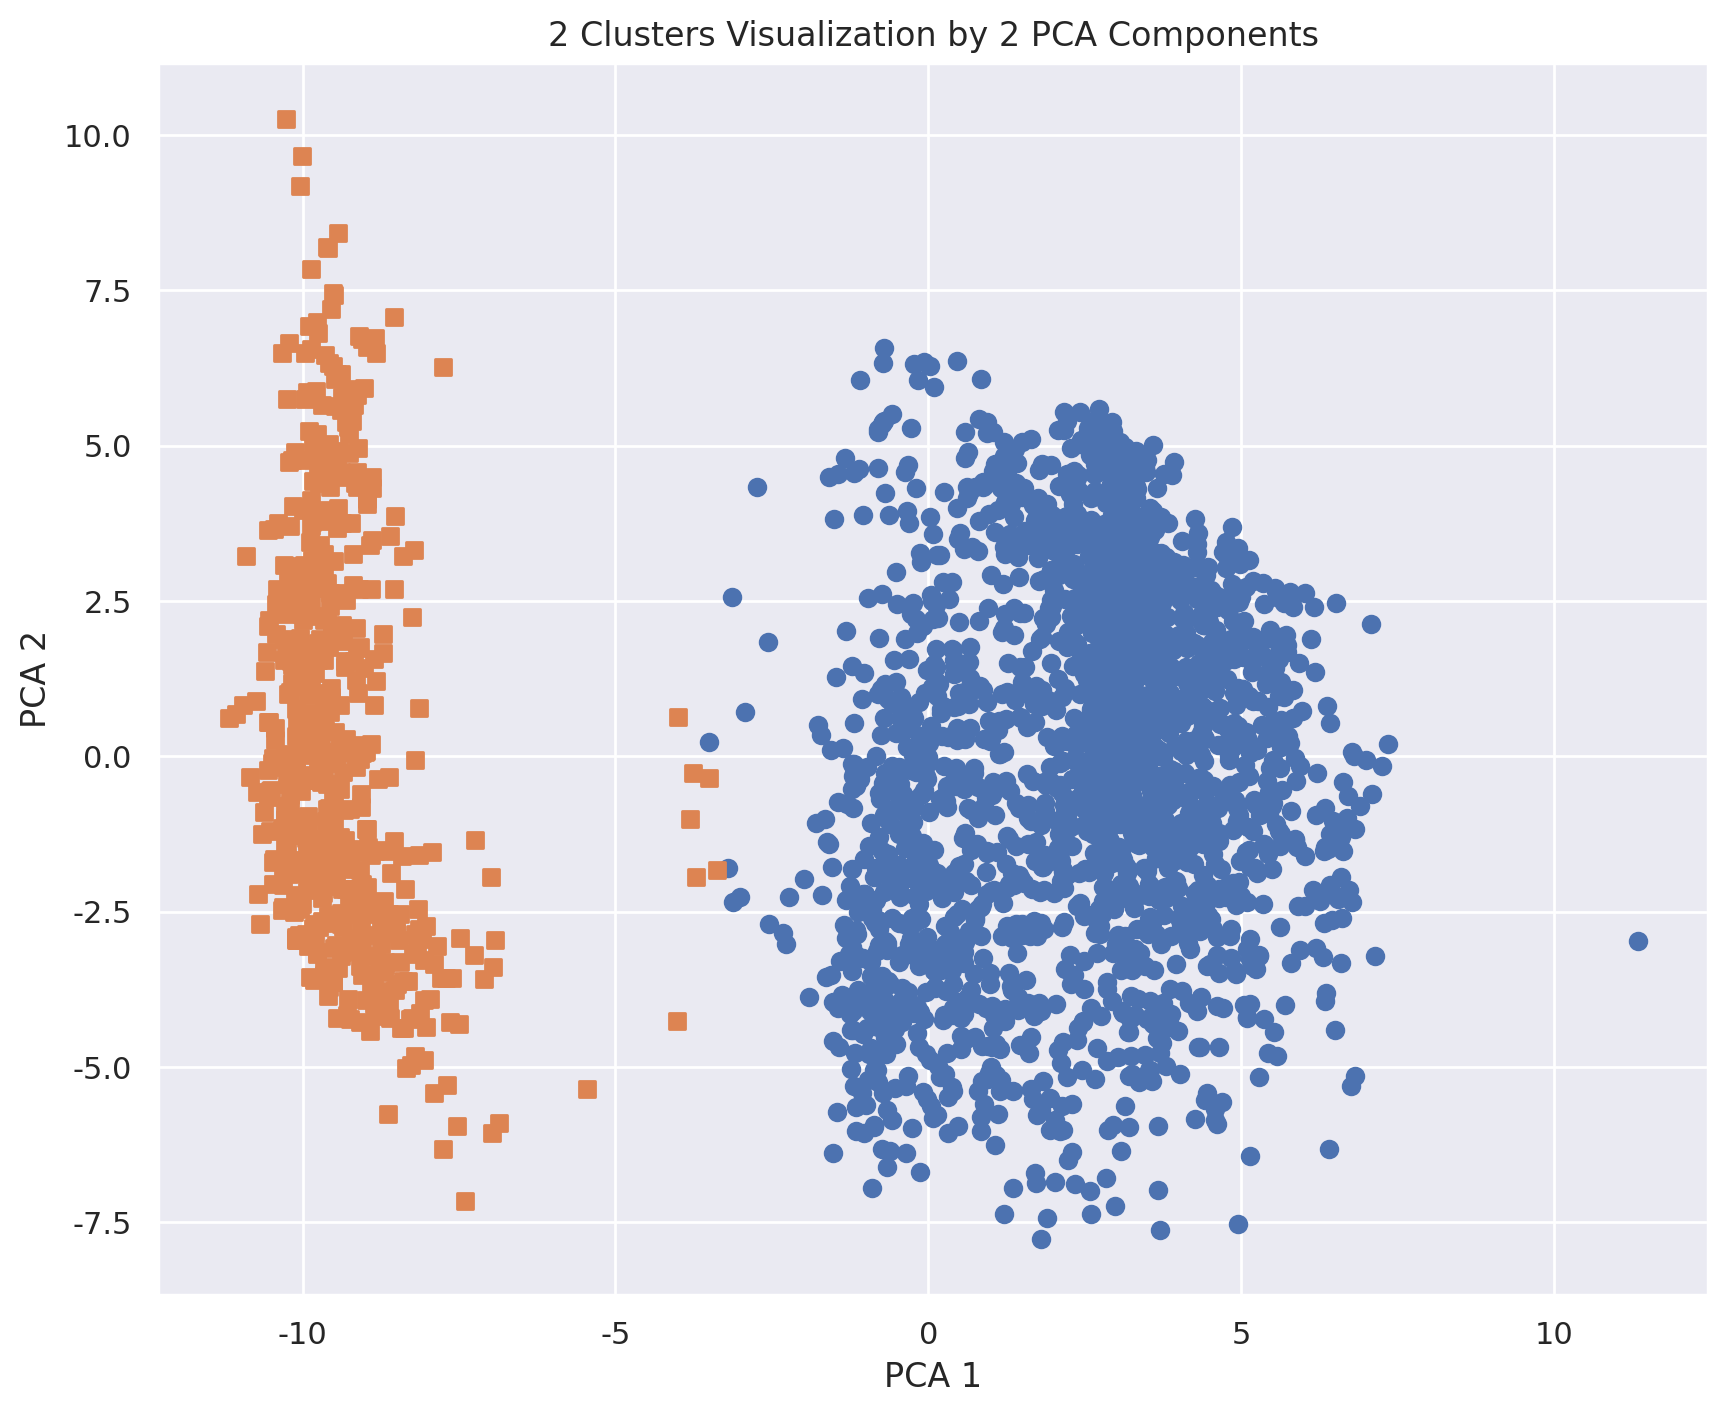

In [220]:
plt.scatter(x=df.loc[marker0_ind, 'pca_x'], y=df.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=df.loc[marker1_ind, 'pca_x'], y=df.loc[marker1_ind, 'pca_y'], marker='s')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2 Clusters Visualization by 2 PCA Components')
plt.show()